## Super resolution on Imagenet

In [ ]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

In [ ]:
from torchvision.models import vgg16_bn

In [ ]:
torch.cuda.set_device(0)

In [ ]:
path = Path('data/imagenet')
path_hr = path/'train'
path_lr = path/'small-64/train'
path_mr = path/'small-256/train'

# note: this notebook relies on models created by lesson7-superres.ipynb
path_pets = untar_data(URLs.PETS)

In [ ]:
il = ImageList.from_folder(path_hr)

In [ ]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [ ]:
assert path.exists(), f"need imagenet dataset @ {path}"
# create smaller image sets the first time this nb is run
sets = [(path_lr, 64), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [ ]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8200: bs,size=16,256  
else:           bs,size=8,256
print(f"using bs={bs}, size={size}, have {free}MB of GPU RAM free")

arch = models.resnet34
# sample = 0.1
sample = False

tfms = get_transforms()

using bs=8, size=256, have 8109MB of GPU RAM free


In [ ]:
src = ImageImageList.from_folder(path_lr)

In [ ]:
if sample: src = src.filter_by_rand(sample, seed=42)

In [ ]:
src = src.split_by_rand_pct(0.1, seed=42)

In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.relative_to(path_lr))
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [ ]:
data = get_data(bs,size)

## Feature loss

In [ ]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [ ]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

In [ ]:
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [ ]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight)
gc.collect();

In [ ]:
learn.unfreeze()

In [ ]:
# relies on first running lesson7-superres.ipynb which created the following model
learn.load((path_pets/'small-96'/'models'/'2b').absolute());

In [ ]:
learn.fit_one_cycle(1, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.347123,2.385141,0.229566,0.293816,0.322328,0.146045,0.460049,0.638133,0.295204


In [ ]:
learn.save('imagenet')

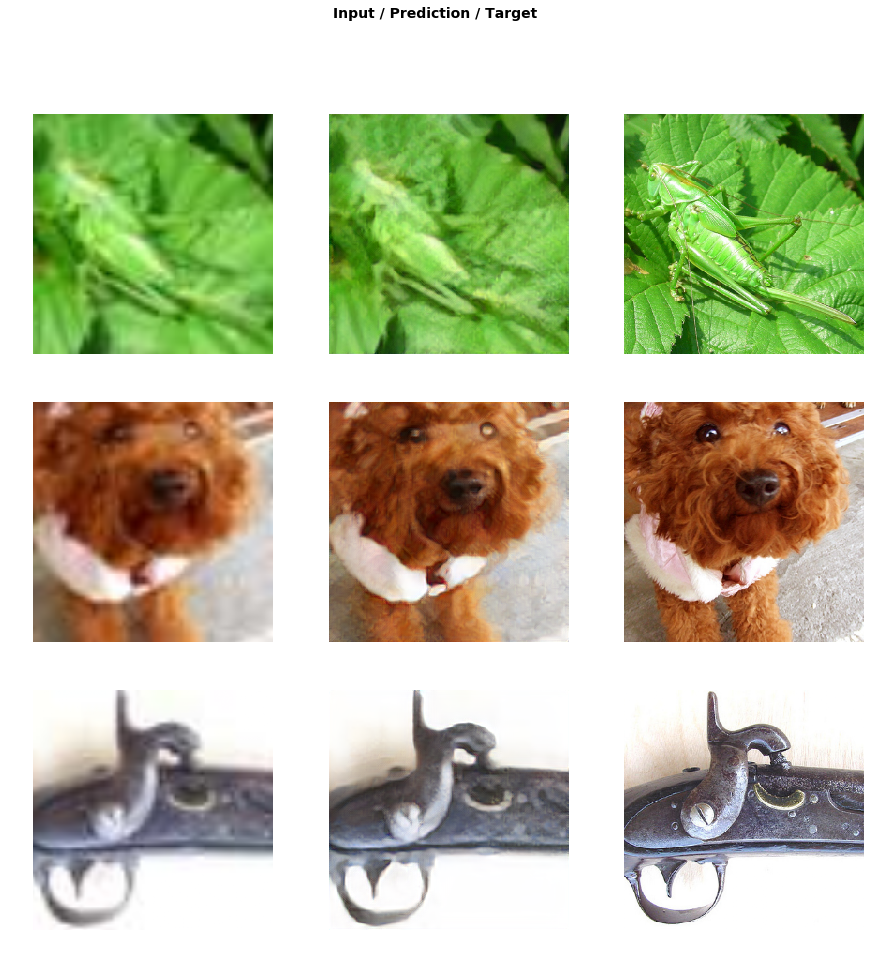

In [ ]:
learn.show_results(rows=3, imgsize=5)

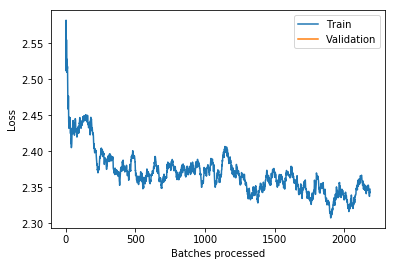

In [ ]:
learn.recorder.plot_losses()

## Test

In [ ]:
_=learn.load('imagenet')

In [ ]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.relative_to(path_mr))
          .transform(get_transforms(), size=(820,1024), tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))

In [ ]:
learn.data = data_mr

In [ ]:
# here put some image you want to enhance, e.g. the original notebook uses a single video frame from a powerpoint presentation on dropout paper
fn = path_pets/'other'/'dropout.jpg'

In [ ]:
img = open_image(fn); img.shape

torch.Size([3, 850, 1042])

In [ ]:
_,img_hr,b = learn.predict(img)

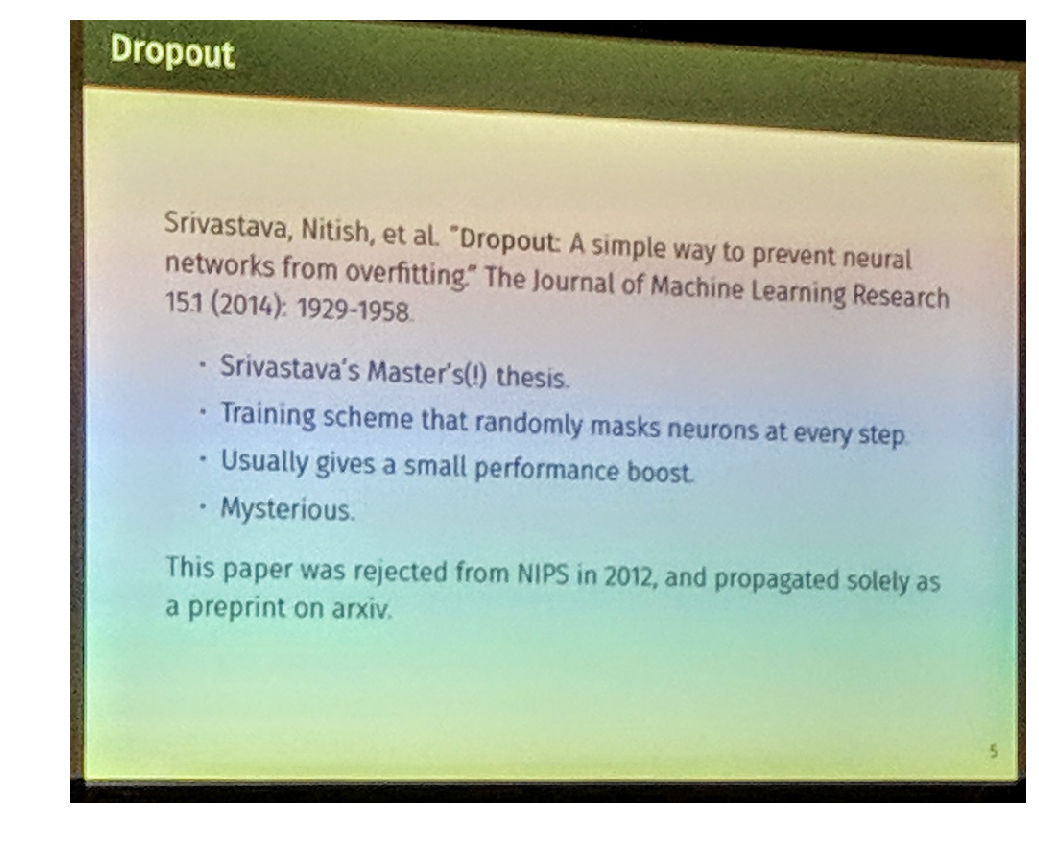

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


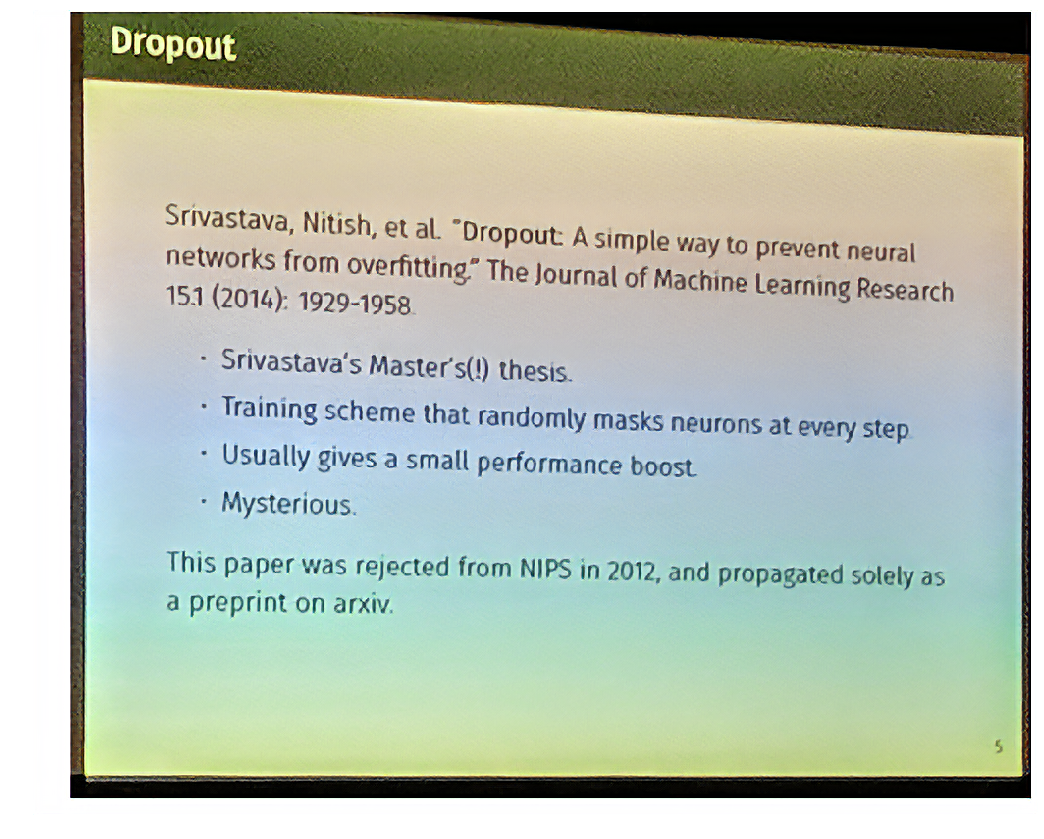

In [ ]:
Image(img_hr).show(figsize=(18,15))